In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import copy
import math

In [ ]:
file = files.upload()

In [ ]:
df = pd.read_csv("/content/NER-Dataset-Train.csv")

In [ ]:
df.head()

,Sentences with BIO tags
0,@LewisDixon O Trust O me O ! O im O gonna O be...
1,@joshHnumber1fan O its O okay O then O .. O ma...
2,"Asprin O , O check O , O cup O of O tea O , O ..."
3,@angelportugues O LMAO O ! O When O is O tht O...
4,The O Basic O Step O Before O You O Even O Sta...


#Creating transition matrix

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Sample data (replace this with your actual data)
X = ["This is a positive sentence.", "Negative sentiment in this one.", "Another positive example.", "Negative review here.", "Positive feedback."]
y = [1, 0, 1, 0, 1]  # Binary labels (1 for positive, 0 for negative)

# Initialize vectorizer and classifier (replace with your actual models)
vectorizer = TfidfVectorizer()
classifier = SVC()

# Transform text data into feature vectors
X_transformed = vectorizer.fit_transform(X)

# Initialize metrics lists for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Initialize StratifiedKFold with 5 folds
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Iterate through each fold
for train_index, test_index in kf.split(X_transformed, y):
    X_train_fold, X_test_fold = X_transformed[train_index], X_transformed[test_index]
    y_train_fold, y_test_fold = np.array(y)[train_index], np.array(y)[test_index]

    # Train the classifier on the training fold
    classifier.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = classifier.predict(X_test_fold)

    # Calculate metrics for this fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold)
    recall_fold = recall_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)

    # Append metrics to lists
    accuracy_list.append(accuracy_fold)
    precision_list.append(precision_fold)
    recall_list.append(recall_fold)
    f1_list.append(f1_fold)

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_list)
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1 = np.mean(f1_list)

# Print individual fold results
for i in range(3):
    print(f"Fold {i + 1}: Accuracy={accuracy_list[i]}, Precision={precision_list[i]}, Recall={recall_list[i]}, F1-Score={f1_list[i]}")

# Print average results
print("\nAverage Results:")
print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1-Score: {average_f1}")


Fold 1: Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666
Fold 2: Accuracy=0.5, Precision=0.5, Recall=1.0, F1-Score=0.6666666666666666
Fold 3: Accuracy=1.0, Precision=1.0, Recall=1.0, F1-Score=1.0

Average Results:
Average Accuracy: 0.6666666666666666
Average Precision: 0.6666666666666666
Average Recall: 1.0
Average F1-Score: 0.7777777777777777


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


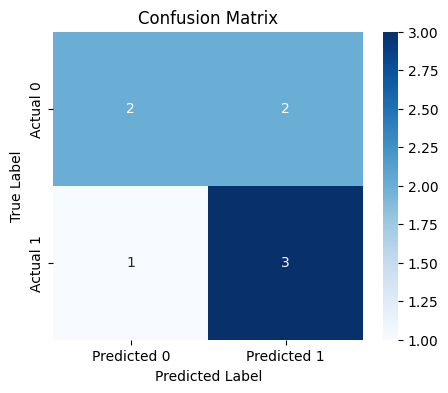

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample true labels and predicted labels (replace these with your actual data)
y_true = [1, 0, 1, 0, 1, 0, 1, 0]
y_pred = [1, 0, 1, 0, 1, 1, 0, 1]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Calculating start probability

In [ ]:
def calculate_start_probability(BIO_tags_as_initial_count,count_of_each_BIO_tags):
    start_probability = [0]*3
    for i in range(3):
        start_probability[i] = (BIO_tags_as_initial_count[i])/count_of_each_BIO_tags[i]
    return start_probability

#Calculate transition probability for unigram model

In [ ]:
def calculate_transition_probability_unigram(X_train):
    transition_count_t1_t2,BIO_tags_as_initial_count,count_of_each_BIO_tags = create_transition_matrix(X_train)
    calculate_start_probability(BIO_tags_as_initial_count,count_of_each_BIO_tags)

    transition_probability_t1 = copy.deepcopy(count_of_each_BIO_tags)
    N = sum(count_of_each_BIO_tags)
    for i in range(0,3):
        transition_probability_t1[i] = transition_probability_t1[i]/N

    return transition_probability_t1,count_of_each_BIO_tags,BIO_tags_as_initial_count

#Calculating transition probability for bigram model

In [ ]:
def calculate_transition_probability_bigram(X_train):
    transition_count_t1_t2,BIO_tags_as_initial_count,count_of_each_BIO_tags = create_transition_matrix(X_train)
    calculate_start_probability(BIO_tags_as_initial_count,count_of_each_BIO_tags)

    transition_probability_t1_t2 = copy.deepcopy(transition_count_t1_t2)

    for i in range(0,3):
        for j in range(0,3):
            transition_probability_t1_t2[i][j] = (transition_probability_t1_t2[i][j])/(count_of_each_BIO_tags[i] + 1)

    return transition_probability_t1_t2,count_of_each_BIO_tags,BIO_tags_as_initial_count

#Extracting distinct words from the dataset

In [ ]:
def extracting_distinct_words(X_train):
    distinct_words = set()
    i = 0
    for i in X_train:
        line = list(i.split(" "))
        length  = int(len(line))
        for j in range(0,length,2):
            distinct_words.add(line[j])

    words = {}
    j = 0
    for i in distinct_words:
        words[i] = j
        j = j + 1
    return words

#Calculating emission count

In [ ]:
def calculate_emission_count(X_train):
    words = extracting_distinct_words(X_train)
    BIO_tags = {'B':0,'I':1,'O':2}

    count_of_distinct_words = len(words)
    #declaring emission count matrix
    emission_count = []
    for i in range(0,count_of_distinct_words):
        t = []
        for j in range(0,3):
            t.append(float(0))
        emission_count.append(t)

    for i in range(0,len(X_train)):
        linex = X_train[i].split(" ")
        length = len(linex)

        for j in range(0,length,2):
            emission_count[words[linex[j]]][BIO_tags[linex[j+1]]] += 1
    return emission_count,count_of_distinct_words,words

#Calculating emission probability

In [ ]:
def calculate_emission_probability(X_train,count_of_each_BIO_tags):
    emission_count,count_of_distinct_words,words = calculate_emission_count(X_train)
    emission_probability = copy.deepcopy(emission_count)

    for i in range(0,count_of_distinct_words):
        for j in range(0,3):
            emission_probability[i][j] = (emission_probability[i][j])/(count_of_each_BIO_tags[j])

    return emission_probability,words

#Finding most frequent BIO tag

In [ ]:
def most_frequent_BIO_tags(count_of_each_BIO_tags):
    BIO_tags = {'B':0,'I':1,'O':2}
    for i in range(0,3):
        if(count_of_each_BIO_tags[i]==max(count_of_each_BIO_tags)):
            most_frequent_tag_index = i
            break

    for i in BIO_tags:
        if(BIO_tags[i]==most_frequent_tag_index):
            most_frequent_tag = i
    return most_frequent_tag

#Viterbi Algorithm(Bigram)

In [ ]:
def viterbiAlgorithm_Bigram(transition_probability,emission_probability,start_probability,count_of_each_pos_tags,pos_tags,words,most_frequent_tag,testX):
    count_of_distinct_pos_tags = len(pos_tags)
    BIO_tags = {'B':0,'I':1,'O':2}

    #declaring matrix to calculate probability at each k
    prob_and_seq = []
    cursen = testX.split(" ")
    curlen = len(cursen)
    cursenlen = int(curlen/2)
    predicted_seq_of_pos_tags = []

    for i in range(0,count_of_distinct_pos_tags):
        t = []
        for j in range(0,cursenlen):
            t.append([0,"O"])
        prob_and_seq.append(t)
    #end of matrix creation

    for j in pos_tags.keys():
        if cursen[0] in words.keys():
            prob_and_seq[pos_tags[j]][0][0] = start_probability[pos_tags[j]] * emission_probability[words[cursen[0]]][pos_tags[j]]
            prob_and_seq[pos_tags[j]][0][1] = pos_tags[j]

        else:
            prob_and_seq[pos_tags[j]][0][0] = start_probability[pos_tags[j]]
            prob_and_seq[pos_tags[j]][0][1] = pos_tags[j]



    for i in range(1,cursenlen):
        if cursen[i*2] in words.keys():
            for j in pos_tags.keys(): #every prev state
                prev_prob = prob_and_seq[pos_tags[j]][i-1][0]

                for k in pos_tags.keys():#every cur state
                    max_prob = prob_and_seq[pos_tags[k]][i][0]
                    max_postag = prob_and_seq[pos_tags[k]][i][1]

                    p1 = transition_probability[pos_tags[j]][pos_tags[k]]
                    p2 = emission_probability[words[cursen[i*2]]][pos_tags[k]]

                    cur_prob = prev_prob + math.log(p1 + 1) + math.log(p2 + 1)

                    if max_prob<=cur_prob:
                            max_prob = cur_prob
                            prob_and_seq[pos_tags[k]][i][0] = max_prob
                            prob_and_seq[pos_tags[k]][i][1] = j

        else:
            for j in pos_tags.keys(): #every prev state
                prev_prob = prob_and_seq[pos_tags[j]][i-1][0]

                for k in pos_tags.keys():#every cur state
                    if (k==most_frequent_tag):
                        max_prob = prob_and_seq[pos_tags[k]][i][0]
                        max_postag = prob_and_seq[pos_tags[k]][i][1]

                        p1 = transition_probability[pos_tags[j]][pos_tags[k]]

                        cur_prob = prev_prob + math.log(p1 + 1)

                        if max_prob<=cur_prob:
                                max_prob = cur_prob
                                prob_and_seq[pos_tags[k]][i][0] = max_prob
                                prob_and_seq[pos_tags[k]][i][1] = j
                    else:
                        prob_and_seq[pos_tags[k]][i][0] = float(0)
                        prob_and_seq[pos_tags[k]][i][1] = "O"

            #print(prob_and_seq[pos_tags[k]][i][1])

    maxiprob = prob_and_seq[0][cursenlen-1][0]
    prevpostag = prob_and_seq[0][cursenlen-1][1]

    for i in pos_tags.keys():
        if prob_and_seq[pos_tags[i]][cursenlen-1][0]>=maxiprob:
            maxiprob = prob_and_seq[pos_tags[i]][cursenlen-1][0]
            prevpostag = prob_and_seq[pos_tags[i]][cursenlen-1][1]
            maxipostag = i


    predicted_seq_of_pos_tags.append(maxipostag)

    for i in range(cursenlen-2,-1,-1):
        predicted_seq_of_pos_tags.append(prevpostag)
        prevpostag = prob_and_seq[pos_tags[prevpostag]][i][1]


    predicted_seq_of_pos_tags.reverse()

    #print(predicted_seq_of_pos_tags)
    return predicted_seq_of_pos_tags

#Viterbi Algorithm(Unigram)

In [ ]:
def viterbiAlgorithm_Unigram(transition_probability,emission_probability,start_probability,count_of_each_pos_tags,pos_tags,words,most_frequent_tag,testX):
    count_of_distinct_pos_tags = len(pos_tags)


    #declaring matrix to calculate probability at each k
    prob_and_seq = []
    cursen = testX.split(" ")
    curlen = len(cursen)
    cursenlen = int(curlen/2)
    predicted_seq_of_pos_tags = []

    for i in range(0,count_of_distinct_pos_tags):
        t = []
        for j in range(0,cursenlen):
            t.append(0)
        prob_and_seq.append(t)
    #end of matrix creation

    for j in pos_tags.keys():
        if cursen[0] in words.keys():
            prob_and_seq[pos_tags[j]][0] = start_probability[pos_tags[j]] * emission_probability[words[cursen[0]]][pos_tags[j]]

        else:
            prob_and_seq[pos_tags[j]][0] = start_probability[pos_tags[j]]



    for i in range(1,cursenlen):
        if cursen[i*2] in words.keys():
            for k in pos_tags.keys():#every cur state
                max_prob = prob_and_seq[pos_tags[k]][i]
                max_postag = prob_and_seq[pos_tags[k]][i]

                p1 = transition_probability[pos_tags[k]]
                p2 = emission_probability[words[cursen[i*2]]][pos_tags[k]]

                cur_prob = math.log(p1 + 1) + math.log(p2 + 1)

                if max_prob<=cur_prob:
                        max_prob = cur_prob
                        prob_and_seq[pos_tags[k]][i] = max_prob


        else:
            for k in pos_tags.keys():#every cur state
                if (k==most_frequent_tag):
                    max_prob = prob_and_seq[pos_tags[k]][i]

                    p1 = transition_probability[pos_tags[k]]

                    cur_prob = math.log(p1 + 1)

                    if max_prob<=cur_prob:
                            max_prob = cur_prob
                            prob_and_seq[pos_tags[k]][i] = max_prob

                else:
                    prob_and_seq[pos_tags[k]][i] = float(0)


            #print(prob_and_seq[pos_tags[k]][i][1])



    for j in range(cursenlen-1,-1,-1):
        maxiprob = 0

        for i in pos_tags.keys():
            if prob_and_seq[pos_tags[i]][j]>=maxiprob:
                maxiprob = prob_and_seq[pos_tags[i]][j]
                maxipostag = i
        predicted_seq_of_pos_tags.append(maxipostag)


    predicted_seq_of_pos_tags.reverse()

    #print(predicted_seq_of_pos_tags)
    return predicted_seq_of_pos_tags

#Running Viterbi(Bigram Model) algo to predict the BIO tags associated with each word of a sentence

In [ ]:
def test_bigram(X_test,transition_probability_t1_t2,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag):
    predicted_y_bigram = []
    for i in X_test:
        predicted_y_bigram.append(viterbiAlgorithm_Bigram(transition_probability_t1_t2,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag,i))
    return predicted_y_bigram

#Running Viterbi(Unigram Model) algo to predict the BIO tags associated with each word of a sentence

In [ ]:
def test_unigram(X_test,transition_probability_t1,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag):
    predicted_y_unigram = []
    for i in X_test:
        predicted_y_unigram.append(viterbiAlgorithm_Unigram(transition_probability_t1,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag,i))
    return predicted_y_unigram

#Calculating Accuracy

In [ ]:
def calculate_accuracy(predicted_y):
    k = 0
    accuracy = []
    for i in X_test:
        count = 0
        actualtags_y = i.split(" ")
        curlen = int(len(actualtags_y)/2)
        for j in range(0,curlen):
            if predicted_y[k][j]==actualtags_y[j*2 + 1]:
                count +=1
        k +=1
        accuracy.append(count/curlen)
    avg_accuracy = sum(accuracy)/len(accuracy)
    return avg_accuracy

#Splitting dataset into 80:20 ratio

In [ ]:
start = int(len(df)*0.8)
X_train = df.iloc[:start,0]
X_test = df.iloc[start:,0]

#calculating parameters for unigram
transition_probability_t1,count_of_each_BIO_tags,BIO_tags_as_initial_count = calculate_transition_probability_unigram(X_train)
start_probability = calculate_start_probability(BIO_tags_as_initial_count,count_of_each_BIO_tags)
emission_probability,words = calculate_emission_probability(X_train,count_of_each_BIO_tags)
most_frequent_tag = most_frequent_BIO_tags(count_of_each_BIO_tags)

#running Unigram HMM Model
predicted_y_uni = test_unigram(X_test,transition_probability_t1,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag)
accuracy = calculate_accuracy(predicted_y_uni)
print("Accuracy of unigram model = ",round(accuracy*100,2),'%',sep="")

#calculating parameters for bigram
transition_probability_t1_t2,count_of_each_BIO_tags,BIO_tags_as_initial_count = calculate_transition_probability_bigram(X_train)
start_probability = calculate_start_probability(BIO_tags_as_initial_count,count_of_each_BIO_tags)
emission_probability,words = calculate_emission_probability(X_train,count_of_each_BIO_tags)
most_frequent_tag = most_frequent_BIO_tags(count_of_each_BIO_tags)

#running bigram HMM Model
predicted_y_bi = test_bigram(X_test,transition_probability_t1_t2,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag)
accuracy = calculate_accuracy(predicted_y_bi)
print("Accuracy of bigram model at Fold = ",round(accuracy*100,2),'%',sep="")

Accuracy of unigram model = 91.63%
Accuracy of bigram model at Fold = 93.74%


#5-fold cross Validation

In [ ]:
total_count = len(df)
fold = 5
split_ratio = round(1/fold)
avg_accuracy_uni = 0
avg_accuracy_bi = 0
BIO_tags = {'B':0,'I':1,'O':2}

for i in range(fold):
    start = round(total_count/fold)*(i)
    end = round(total_count/fold)*(i+1)

    X_train = df.iloc[np.r_[0:start,end:],-1].values
    X_test = df.iloc[start:end,-1].values

    #calculating parameters for unigram
    transition_probability_t1,count_of_each_BIO_tags,BIO_tags_as_initial_count = calculate_transition_probability_unigram(X_train)
    start_probability = calculate_start_probability(BIO_tags_as_initial_count,count_of_each_BIO_tags)
    emission_probability,words = calculate_emission_probability(X_train,count_of_each_BIO_tags)
    most_frequent_tag = most_frequent_BIO_tags(count_of_each_BIO_tags)

    #running Unigram HMM Model
    predicted_y_uni = test_unigram(X_test,transition_probability_t1,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag)
    accuracy = calculate_accuracy(predicted_y_uni)
    print("Accuracy of unigram model at Fold ",i," = ",accuracy)
    avg_accuracy_uni += accuracy

    #calculating parameters for bigram
    transition_probability_t1_t2,count_of_each_BIO_tags,BIO_tags_as_initial_count = calculate_transition_probability_bigram(X_train)
    start_probability = calculate_start_probability(BIO_tags_as_initial_count,count_of_each_BIO_tags)
    emission_probability,words = calculate_emission_probability(X_train,count_of_each_BIO_tags)
    most_frequent_tag = most_frequent_BIO_tags(count_of_each_BIO_tags)

    #running bigram HMM Model
    predicted_y_bi = test_bigram(X_test,transition_probability_t1_t2,emission_probability,start_probability,count_of_each_BIO_tags,BIO_tags,words,most_frequent_tag)
    accuracy = calculate_accuracy(predicted_y_bi)
    print("Accuracy of bigram model at Fold ",i," = ",accuracy)
    avg_accuracy_bi += accuracy

avg_accuracy_uni *= (1/fold)
print("Average_accuracy of Unigram Model = ",round(avg_accuracy_uni*100,2),'%',sep="")

avg_accuracy_bi *= (1/fold)
print("Average_accuracy of Bigram Model = ",round(avg_accuracy_bi*100,2),'%',sep="")

Accuracy of unigram model at Fold  0  =  0.939956854591589
Accuracy of bigram model at Fold  0  =  0.9383650330871498
Accuracy of unigram model at Fold  1  =  0.9365347469056349
Accuracy of bigram model at Fold  1  =  0.933035009001059
Accuracy of unigram model at Fold  2  =  0.9366416151952979
Accuracy of bigram model at Fold  2  =  0.934558522362205
Accuracy of unigram model at Fold  3  =  0.9540298719401834
Accuracy of bigram model at Fold  3  =  0.9541137519201351
Accuracy of unigram model at Fold  4  =  0.9467918090342533
Accuracy of bigram model at Fold  4  =  0.9429472851919156
Average_accuracy of Unigram Model = 94.28%
Average_accuracy of Bigram Model = 94.06%
